# CNN 숫자 학습

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np
 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


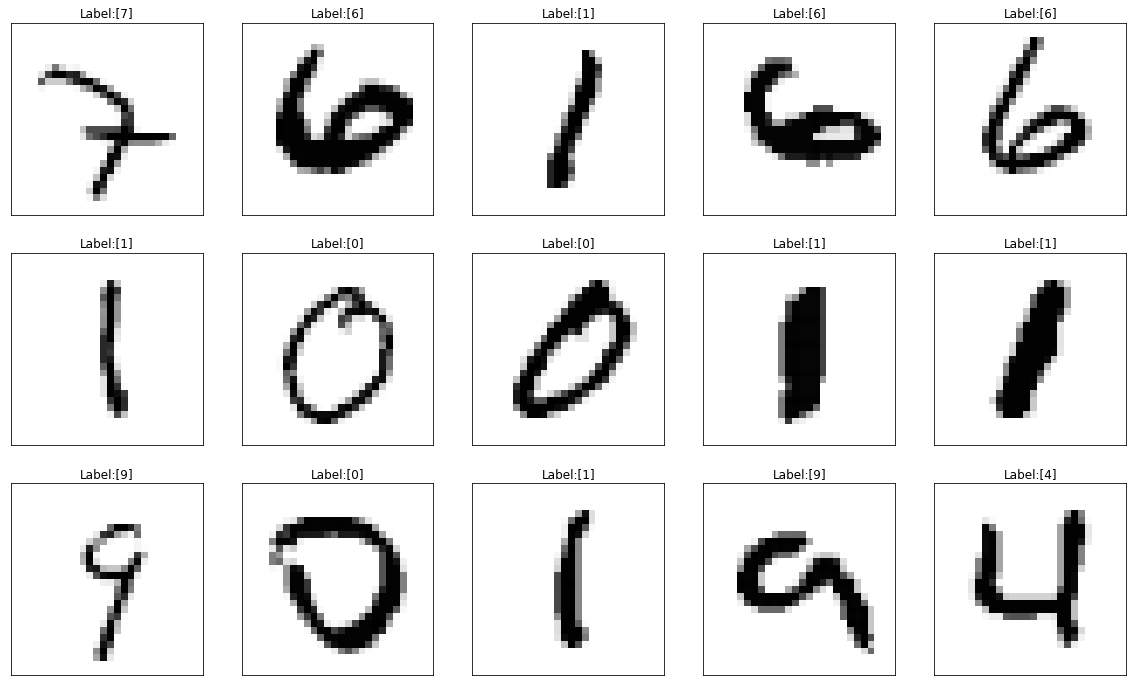

In [7]:
# 렌덤으로 데이터 보기
sess = tf.Session()
figure = plt.figure(figsize=(20, 12))
for i, index in enumerate(np.random.choice(mnist.train.num_examples, size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    a = sess.run(tf.argmax(mnist.train.labels[index:index+1], 1))
    # 각각의 이미지를 보여줌
    ax.imshow(mnist.train.images[index].reshape(28, 28), cmap='Greys', interpolation='nearest')
    ax.set_title("Label:{}".format(a))

In [8]:
# 학습의 속도와 Epoch, 그리고 데이터를 가져올 batch의 크기를 지정해 줍니다.
learning_rate = 0.001
training_epochs = 3
batch_size = 100

In [9]:
# 먼저 이미지의 정보를 담을 X를 placeholder로 지정해줍니다.
X = tf.placeholder(tf.float32, [None, 784])
 
# 가져온 정보를 이미지화 하기 위하여 reshape합니다.
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
 
# 이미지의 Label 정보를 담을 Y 역시 placeholder로 지정해줍니다.
Y = tf.placeholder(tf.float32, [None, 10])

In [10]:
# CNN에서 우리는 결국 제대로 된 Filter를 가진 Model을 구축해 나갈 것입니다.
# 다시 말해 Filter를 학습시켜 이미지를 제대로 인식하도록 할 것입니다.
# 그렇기에 Filter를 변수 W로 표현합니다.
# 32개의 3 x 3 x 1의 Filter를 사용하겠다는 뜻입니다.
 
W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))

In [11]:
# 간단하게 conv2d 함수를 사용하면 됩니다.
L1 = tf.nn.conv2d(X_img, W1, strides=[1,1,1,1], padding='SAME')

In [12]:
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [13]:
# W2는 두번째 Conv의 Filter입니다.
# 다만 이전 과정 Filter의 개수가 32개였기 때문에
# 그 숫자에 맞추어 depth를 32로 지정해줍니다.
 
W2 = tf.Variable(tf.random_normal([3,3,32,64], stddev=0.01))

In [14]:
L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [15]:
# Softmax를 통한 FC layer를 활용하기 위해 shape를 변환해줍니다.
# 위에서 L2는 일종의 X 값이라고도 볼 수 있습니다.
# Softmax를 거칠 예측값(WX+b)을 만들어주기 위해 reshape 합니다.
 
L2 = tf.reshape(L2, [-1, 7*7*64])

In [16]:
# W3를 설정하는데 Xavier initializing을 통해 초기값을 설정할 것입니다.
# reshape된 L2의 shape이 [None, 7*7*64] 였으므로
# W3의 shape은 [7*7*64, num_label]이 됩니다.
 
W3 = tf.get_variable("W3", shape=[7*7*64, 10], initializer = tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))

In [17]:
hypothesis = tf.matmul(L2, W3) + b

In [18]:
# Softmax 함수를 직접 사용하는 대신에 sofmax_corss_entropy_with_logits을 사용할 수 있습니다.
# 인자로 logits과 label을 전달해주면 됩니다.
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
 
# 이전까지는 Gradient Descent Optimizer를 사용하였지만
# 좀 더 학습성과가 뛰어나다고 알려져있는 Adam Optimizer를 사용하겠습니다.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
 
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)
 
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
 
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
 
print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 0.339839271
Epoch: 0002 cost = 0.096928370
Epoch: 0003 cost = 0.069871029
Learning Finished!


Accuracy: 0.98
Label:  [5]
Prediction:  [5]


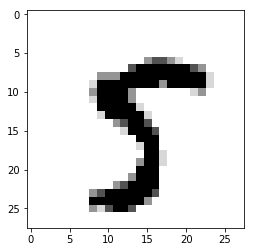

In [20]:
# 먼저 늘 그래왔듯 accuracy op를 만들고요.
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
 
# MNIST의 테스트용 이미지를 feed_dict로 전달합니다.
print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
 
# 랜덤하게 하나의 이미지를 정확히 맞추는지 역시 테스트가 가능합니다.
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(hypothesis, 1), feed_dict={X: mnist.test.images[r:r + 1]}))
 
# matplotlib을 사용하여 랜덤하게 뽑힌 이미지를 출력할 수도 있습니다.
plt.imshow(mnist.test.images[r].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

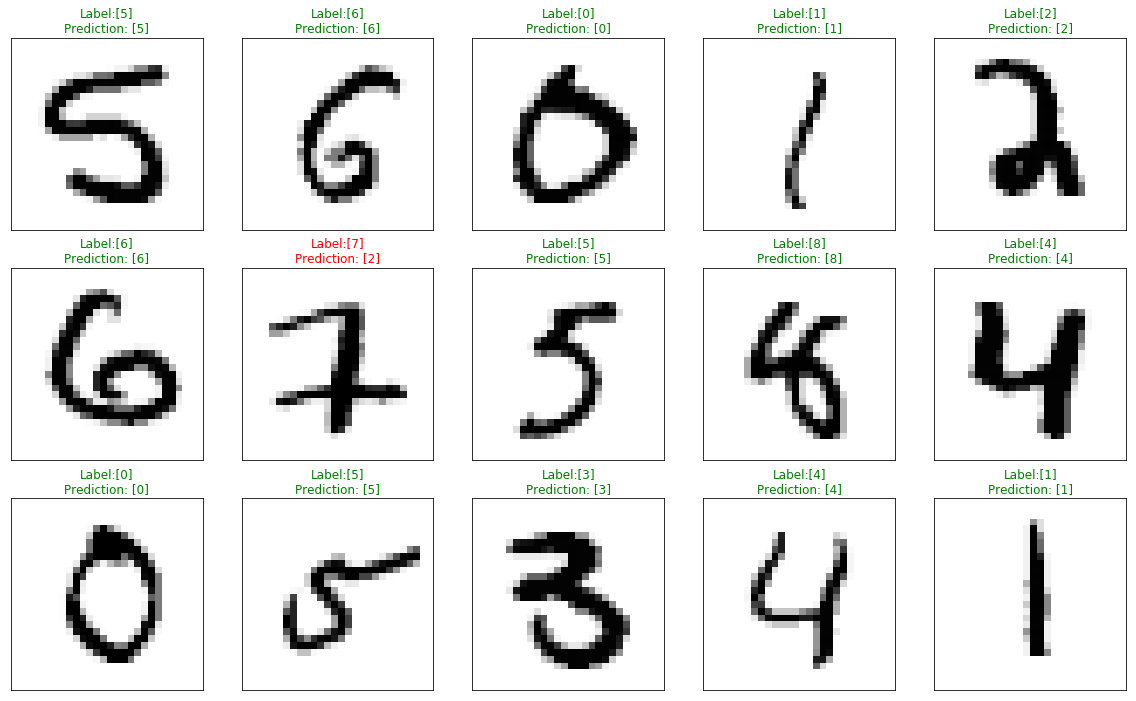

In [23]:
figure = plt.figure(figsize=(20, 12))
for i, index in enumerate(np.random.choice(mnist.test.num_examples, size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # 각각의 이미지를 보여줌
    a = sess.run(tf.argmax(mnist.test.labels[index:index+1], 1))
    b = sess.run(tf.argmax(hypothesis, 1), feed_dict={X: mnist.test.images[index:index+1]})
    ax.imshow(mnist.test.images[index].reshape(28, 28), cmap='Greys', interpolation='nearest')
    ax.set_title("Label:{}\nPrediction: {}".format(a,b), 
                 color=("green" if a == b else "red"))

# Fashion CNN 학습

In [24]:
# 원문에서는 1.8.0 버전을 사용했지만 18.08월 기준 1.10 이 release되어 1.10.1로 설치했습니다.
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

# 미리 섞여진 fashoin-mnist 의 학습 데이터와 테스트 데이터 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


x_train shape: (60000, 28, 28) y_train shape: (60000,)
60000 train set
10000 test set
y = 2 Pullover


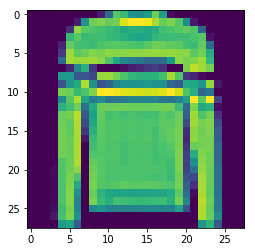

In [25]:
# 학습 셋 크기(shape) - 이미지 크기가 28x28 인 60,000 개의 학습 이미지 데이터, 60,000 개의 레이블
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# 학습 셋과 테스트 셋의 데이터 개수
print(x_train.shape[0], 'train set')
print(x_test.shape[0], 'test set')

# 레이블 정의
fashion_mnist_labels = ["T-shirt/top",  # 인덱스 0
                        "Trouser",      # 인덱스 1
                        "Pullover",     # 인덱스 2 
                        "Dress",        # 인덱스 3 
                        "Coat",         # 인덱스 4
                        "Sandal",       # 인덱스 5
                        "Shirt",        # 인덱스 6 
                        "Sneaker",      # 인덱스 7 
                        "Bag",          # 인덱스 8 
                        "Ankle boot"]   # 인덱스 9

# 이미지 인덱스, 0에서 59,999 사이의 숫자를 선택할 수 있습니다.
img_index = 5
# y_train 은 에서 9까지의 레이블 포함합니다.
label_index = y_train[img_index]
# 레이블 출력해 봅니다. 예를들어 2 Pullover
print ("y = " + str(label_index) + " " +(fashion_mnist_labels[label_index]))
# 학습 데이터 중에서 이미지 한 장을 보여줍니다.
plt.imshow(x_train[img_index])

In [26]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [27]:
print("Number of train data - " + str(len(x_train)))
print("Number of test data - " + str(len(x_test)))

Number of train data - 60000
Number of test data - 10000


In [28]:
# 학습 데이터 셋을 학습 / 평가 셋으로 나눈다. (# 학습 셋: 55,000, 검증 셋: 5000)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# 입력 이미지의 크기를 (28, 28) 에서 (28, 28, 1) 로 배열 차원을 변경(reshape)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# 레이블에 원-핫 인코딩 적용 
# 원-핫 벡터는 단 하나의 차원에서만 1이고, 나머지 차원에서는 0인 벡터입니다.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 학습 셋 크기
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# 학습용, 검증용, 테스트용 데이터셋의 개수
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


In [29]:
model = tf.keras.Sequential()

# 신경망의 첫 번째 레이어에서 입력 데이터 크기를 정의해야 합니다.
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# model.summary()를 통해 모델을 살펴보세요.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
__________

In [30]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [31]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Using TensorFlow backend.


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
54976/55000 [============================>.] - ETA: 0s - loss: 0.6002 - acc: 0.7788
Epoch 00001: val_loss improved from inf to 0.37616, saving model to model.weights.best.hdf5
55000/55000 [==============================] - 75s 1ms/step - loss: 0.6002 - acc: 0.7788 - val_loss: 0.3762 - val_acc: 0.8660
Epoch 2/10
54976/55000 [============================>.] - ETA: 0s - loss: 0.4154 - acc: 0.8488
Epoch 00002: val_loss improved from 0.37616 to 0.31923, saving model to model.weights.best.hdf5
55000/55000 [==============================] - 75s 1ms/step - loss: 0.4153 - acc: 0.8488 - val_loss: 0.3192 - val_acc: 0.8840
Epoch 3/10
54976/55000 [============================>.] - ETA: 0s - loss: 0.3730 - acc: 0.8641- 
Epoch 00003: val_loss improved from 0.31923 to 0.30057, saving model to model.weights.best.hdf5
55000/55000 [==============================] - 75s 1ms/step - loss: 0.3730 - acc: 0.8640 - val_loss: 0.3006 - val_acc: 0.8888
Ep

In [32]:
# 가장 높은 검증 정확도의 가중치 불러오기
model.load_weights('model.weights.best.hdf5')

In [33]:
# 테스트 셋을 통해 모델 평가
score = model.evaluate(x_test, y_test, verbose=0)

# 테스트 정확도
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9064


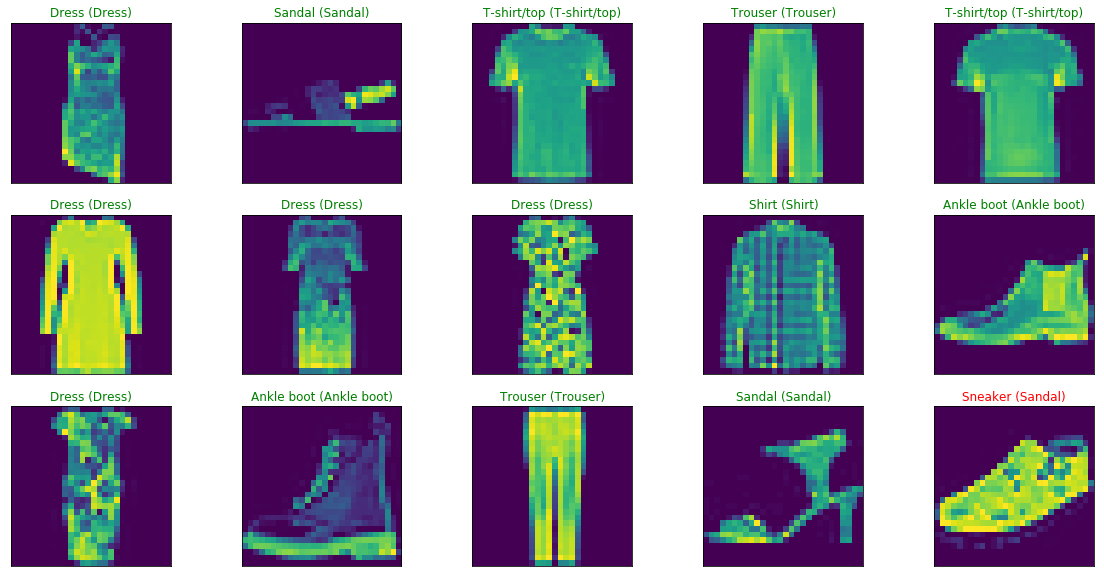

In [34]:
y_hat = model.predict(x_test)

# 무작위 샘플로 10 개의 테스트 이미지와 예측 레이블 및 실제 레이블을 그려줍니다.
figure = plt.figure(figsize=(20, 10))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # 각각의 이미지를 보여줌
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # 각각의 이미지에 예측레이블 (실제레이블) 표시
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))